In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
!pip install wordcloud

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import string
import re
import matplotlib.pyplot as plt
import math
from matplotlib import rc
# from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from bs4 import BeautifulSoup
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sande\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:

train = dataset=pd.read_csv('IMDB Dataset.csv.zip',sep=',')

In [7]:
train.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [8]:
# f = sns.countplot(x='sentiment', data=train)
# f.set_title("Sentiment distribution")
# f.set_xticklabels(['Negative', 'Positive'])
# plt.xlabel("");

In [9]:
# text = " ".join(review for review in train.review)


# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=stopwords.words("english")).generate(text)
# plt.figure()
# plt.imshow(wordcloud, interpolation="bilinear")
# plt.axis("off")
# plt.show();

In [10]:
class Tokenizer:
  
  def clean(self, text):
      no_html = BeautifulSoup(text).get_text()
      clean = re.sub("[^a-z\s]+", " ", no_html, flags=re.IGNORECASE)
      return re.sub("(\s+)", " ", clean)

 
  def tokenize(self, text):
      clean = self.clean(text).lower()
      stopwords_en = stopwords.words("english")
      return [w for w in re.split("\W+", clean) if not w in stopwords_en]

In [11]:
class MultinomialNaiveBayes:
  
    def __init__(self, classes, tokenizer):
      self.tokenizer = tokenizer
      self.classes = classes
      
    def group_by_class(self, X, y):
      data = dict()
      for c in self.classes:
        data[c] = X[np.where(y == c)]
      return data
           
    def fit(self, X, y):
        self.n_class_items = {}
        self.log_class_priors = {}
        self.word_counts = {}
        self.vocab = set()

        n = len(X)
        
        grouped_data = self.group_by_class(X, y)
        
        for c, data in grouped_data.items():
          self.n_class_items[c] = len(data)
          self.log_class_priors[c] = math.log(self.n_class_items[c] / n)
          self.word_counts[c] = defaultdict(lambda: 0)
          
          for text in data:
            counts = Counter(self.tokenizer.tokenize(text))
            for word, count in counts.items():
                if word not in self.vocab:
                    self.vocab.add(word)

                self.word_counts[c][word] += count
                
        return self
      
    def laplace_smoothing(self, word, text_class):
      num = self.word_counts[text_class][word] + 1
      denom = self.n_class_items[text_class] + len(self.vocab)
      return math.log(num / denom)
      
    def predict(self, X):
        result = []
        for text in X:
          
          class_scores = {c: self.log_class_priors[c] for c in self.classes}

          words = set(self.tokenizer.tokenize(text))
          for word in words:
              if word not in self.vocab: continue

              for c in self.classes:
                
                log_w_given_c = self.laplace_smoothing(word, c)
                class_scores[c] += log_w_given_c
                
          result.append(max(class_scores, key=class_scores.get))

        return result

In [12]:
X = train['review'].values
y = train['sentiment'].values
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [13]:
MNB = MultinomialNaiveBayes(
    classes=np.unique(y), 
    tokenizer=Tokenizer()
).fit(X_train, y_train)

In [14]:
y_hat = MNB.predict(X_test)

In [15]:
accuracy_score(y_test, y_hat)


0.8594

In [16]:

import pandas as pd
import requests
from bs4 import BeautifulSoup

# s = input('enter the imdb review page link: ')
s = 'https://www.imdb.com/title/tt8178634/reviews/?ref_=tt_ql_urv'
s1 = s.split('/')
s1 = s1[4]

url = "https://www.imdb.com/title/"+s1+"/reviews/_ajax?ref_=undefined&paginationKey={}"
key = ""
data = {"title": [], "review": []}

while True:
    response = requests.get(url.format(key))
    soup = BeautifulSoup(response.content, "html.parser")
    # Find the pagination key
    pagination_key = soup.find("div", class_="load-more-data")
    if not pagination_key:
        break

    # Update the `key` variable in-order to scrape more reviews
    key = pagination_key["data-key"]
    for title, review in zip(soup.find_all(class_="title"), soup.find_all(class_="text show-more__control")):
        data["title"].append(title.get_text(strip=True))
        data["review"].append(review.get_text())

kgf2 = pd.DataFrame(data)

In [17]:
# kgf2.shape

In [18]:
y = MNB.predict(kgf2['review'])

In [19]:
kgf2['sentiment'] = pd.Series(y)

In [20]:
p = kgf2[kgf2['sentiment'] == 'positive']['title'].count()

In [21]:
n = kgf2[kgf2['sentiment'] == 'negative']['title'].count()

In [22]:
p

723

In [23]:
n

277

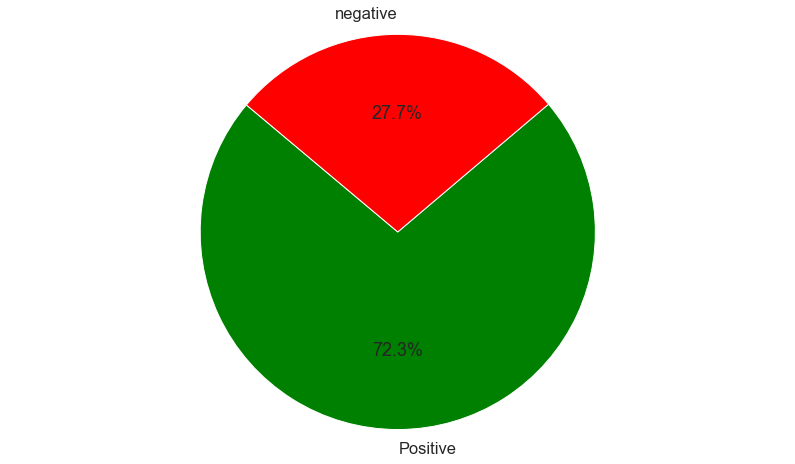

In [24]:
import matplotlib.pyplot as plt

# Data to plot
labels = 'Positive', 'negative'
sizes = [p,n]
colors = ['green', 'red']
#explode = (0.1, 0, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=False, startangle=140)

plt.axis('equal')
plt.show()

In [25]:
# tt10698680 -kgf2
# tt2209764 -trancendence
# tt5074352 - dangal
